# Measure intensity for all channels based on coordinates from the tracked channel

In [1]:
from os import path
import pandas as pd
from IPython.display import display
import numpy as np 
import sys 
import time 
import zarr
import glob
import os
import re
import matplotlib.pyplot as plt

sys.path.append('../src/')

from extract_pixel_data import Extractor

Do not change the code in the cell below

In [2]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'movie_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = os.path.join(base_dir,'datasets')

# in the datasets directory, list pkl files that start with 'all_detections_channel'
files = glob.glob(f'{input_directory}/track_df_c*_cleaned.pkl')

# take the first file
file = files[0]

input_directory_full = os.path.join(input_directory, file)

# find out which channel was detected
match = re.search(r'track_df_c(\d+)_cleaned.pkl', file)
channel_detected = match.group(1)

output_directory = 'datasets'
output_file_name = 'track_df_cleaned_final_full.pkl'
output_directory_full = os.path.join(base_dir,output_directory, output_file_name)

In [3]:
track_df = pd.read_pickle(input_directory_full)
# read the zarr file which contains the data of all three channels 
z = zarr.open(zarr_full_path, mode='r')

The following parameters usually don't have to be adjusted, but you can adjust them based on the sizes of your spots


In [4]:
# radii for sum intensity ("voxel sum") calculation, in [z,y,x]. a radius of 2 will measure 5 pixels across
radii_extractor = [4,2,2] 

# the radius (in pixels) of the shell for background subtraction
# used in "_voxel_sum_adjusted" calculation
background_radius_for_voxel_sum = [1,1,1] 

# number of CPUs used for parallel processing; this isn't currently used
n_cores = -1


Optionally set an offset value in XY between channel 2 and 3

In [5]:
# If you see an offset between the cameras (channel 2 and 3), set that value here to correct for it.
# For example, if channel 2 shows up 4 pixels to the right of channel 2, set offset_x_ch2vs3 to 4

offset_x_ch2vs3 = 0
offset_y_ch2vs3 = 0

offset_ch2vs3 = [offset_y_ch2vs3, offset_x_ch2vs3]


# this line reverses the offset if you detected channel 2
if channel_detected == 2:
    offset_ch3vs2 = [-offset_ch2vs3[0], -offset_ch2vs3[1]]
else:
    offset_ch3vs2 = [0,0]
# if you don't know the offset, it will be estimated below

Calculate intensities for three channels


In [6]:
extractor = Extractor(z, dataframe = track_df, radii=radii_extractor, frame_col_name = 'frame', 
                      radi_col_name = ['sigma_z', 'sigma_y', 'sigma_x'], n_jobs = n_cores)

channels_list = [1,2,3]

for channel in channels_list:

    offset = [0, 0]
    # need to verify that this offset works in the right direction
    if channel_detected == 2 and channel == 2:
        offset = offset_ch3vs2

    if channel_detected != 2 and channel == 2:
        offset = offset_ch2vs3

    col_names = ['mu_z', 'mu_y', 'mu_x']

    # calculate mean, max, sum intensity around the track coordinates
    peak_mean,peak_max,_,_,peak_loc,peak_sum = extractor.extract_pixels_data_fixed_bd(center_col_names = col_names, 
                                                        channel = channel, offset = offset)

    # calculate background subtracted sum intensity: "adjusted voxel sum"
    voxel_sum_array, _, adj_voxel_sum, adj_voxel_sum_vol  = extractor.voxel_sum_fixed_background(center_col_names = ['mu_z', 'mu_y', 'mu_x'], channel = channel,                                                                            
        background_radius=background_radius_for_voxel_sum, offset=offset)

    track_df[f'c{channel}_peak_mean']= peak_mean
    track_df[f'c{channel}_peak_max'] = peak_max
    track_df[f'c{channel}_voxel_sum'] = peak_sum
    track_df[f'c{channel}_voxel_sum_adjusted'] = adj_voxel_sum
    # track_df[f'c{channel}_voxel_sum_adjusted'] = adj_voxel_sum_vol
    track_df[f'c{channel}_peak_x'] = [t[2] for t in peak_loc]
    track_df[f'c{channel}_peak_y'] = [t[1] for t in peak_loc]
    track_df[f'c{channel}_peak_z'] = [t[0] for t in peak_loc]
    
    print(f'Channel {channel} done')

track_df.to_pickle(output_directory_full)
print(f'Track intensities saved, you can continue to the next notebook.')
# track_df.head()

    


Channel 1 done
Channel 2 done
Channel 3 done
Track intensities saved, you can continue to the next notebook.


Optionally use this cell to assess offset between channel 2 and channel 3 peak intensity


Median offset between channel 2 and channel 3 in x: -1
Median offset between channel 2 and channel 3 in y: 0


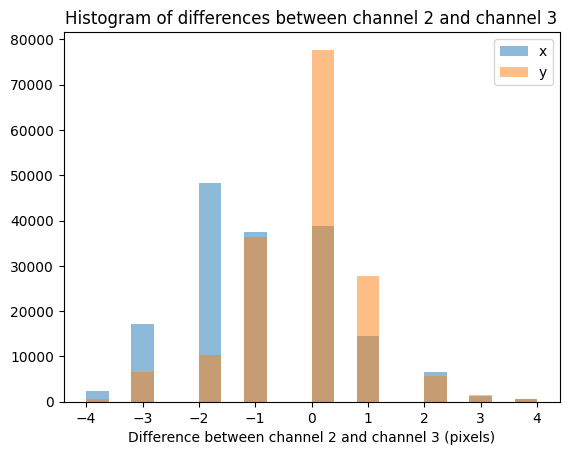

In [7]:
difs_x = track_df['c2_peak_x'] - track_df['c3_peak_x']
difs_x = difs_x[~np.isnan(difs_x)]
offset_x_ch2vs3 = int(difs_x.median())

difs_y = track_df['c2_peak_y'] - track_df['c3_peak_y']
difs_y = difs_y[~np.isnan(difs_y)]
offset_y_ch2vs3 = int(difs_y.median())

plt.hist(difs_x, bins=20, alpha=0.5)
plt.hist(difs_y, bins=20, alpha=0.5)
plt.legend(['x', 'y'])

plt.xlabel('Difference between channel 2 and channel 3 (pixels)')

plt.title('Histogram of differences between channel 2 and channel 3')

print(f'Median offset between channel 2 and channel 3 in x: {offset_x_ch2vs3}')
print(f'Median offset between channel 2 and channel 3 in y: {offset_y_ch2vs3}')


### If there is a systematic offset between the two channels, set those values in the above "set offset" cell and rerun the cells until here

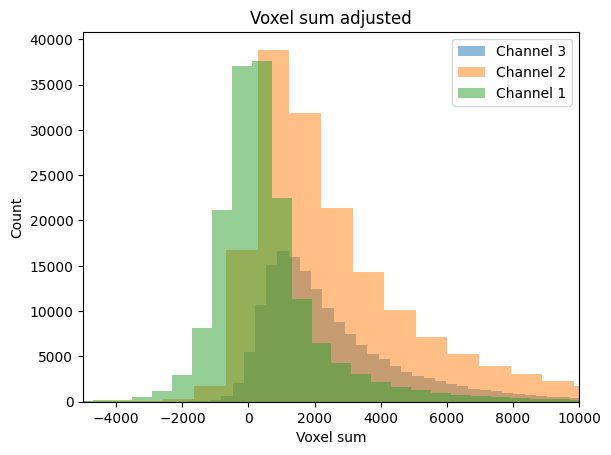

In [8]:
# plot intensity histograms for fun
# change the 'c3_voxel_sum_adjusted' value to plot other intensity metrics

plt.hist(track_df['c3_voxel_sum_adjusted'], bins=100, alpha=0.5, label='Channel 3')
plt.hist(track_df['c2_voxel_sum_adjusted'], bins=100, alpha=0.5, label='Channel 2')
plt.hist(track_df['c1_voxel_sum_adjusted'], bins=100, alpha=0.5, label='Channel 1')

# histogram of three channels with uniform bin sizes
# plt.hist(track_df['c3_voxel_sum_adjusted'], bins=np.linspace(-5000, 10000, 100), alpha=0.5, label='Channel 3')
# plt.hist(track_df['c2_voxel_sum_adjusted'], bins=np.linspace(-5000, 10000, 100), alpha=0.5, label='Channel 2')
# plt.hist(track_df['c1_voxel_sum_adjusted'], bins=np.linspace(-5000, 10000, 100), alpha=0.5, label='Channel 1')

plt.legend()
plt.title('Voxel sum adjusted')
plt.xlabel('Voxel sum')
plt.ylabel('Count')
plt.xlim(-5000, 10000)
plt.show()

In [9]:
# Extract information for channel 1
# track_df['c1_gaussian_amp'] = channel1_gaussians_df['amplitude']
# track_df['c1_mu_x'] = channel1_gaussians_df['mu_x']
# track_df['c1_mu_y'] = channel1_gaussians_df['mu_y']
# track_df['c1_mu_z'] = channel1_gaussians_df['mu_z']
# track_df['c1_sigma_x'] = channel1_gaussians_df['sigma_x']
# track_df['c1_sigma_y'] = channel1_gaussians_df['sigma_y']
# track_df['c1_sigma_z'] = channel1_gaussians_df['sigma_z']

# ### In the below steps dataframe is being cleaned to make column names consistent for next steps 
# ##Renaming columns to maintain data integrity 
# new_col_names = {
#     'amplitude': 'c3_gaussian_amp', 
#     'mu_x': 'c3_mu_x', 
#     'mu_y': 'c3_mu_y', 
#     'mu_z': 'c3_mu_z', 
#     'sigma_x': 'c3_sigma_x', 
#     'sigma_y': 'c3_sigma_y', 
#     'sigma_z': 'c3_sigma_z', 
#     'c2_peak': 'c2_peak_amp', 
#     'c1_peak': 'c1_peak_amp'
# }
# track_df.rename(columns=new_col_names, inplace=True)